## Fast self-forced trajectories

An essential component of the FastEMRIWaveforms (FEW) framework is the rapid evaluation of the inspiral trajectory of the secondary compact object. FEW provides the tools required for users to generate and visualiase these trajectories. Users can also implement their own trajectory models to incorporate additional physics (such as environmental effects or modifications to gravity). We will demonstrate these capabilities in this tutorial.

### ODE classes

#### Parameter conventions

FEW constructs trajectories by integrating the equations of motion of the compact binary; these are a system of ordinary differential equations (ODEs) that describe the evolution of the following parameters:

| Parameter    | Definition |
| :--------: | ------- |
| $p$  | (Dimensionless) semi-latus rectum|
| $e$ | Eccentricity |
| $x_I$    | Cosine of the inclination of the orbital plane|
| $\Phi_\phi$    | Azimuthal GW phase |
| $\Phi_\theta$    | Polar GW phase|
| $\Phi_r$    | Radial GW phase|

The ODE system can be integrated efficiently with adaptive Runge-Kutta techniques. These solvers obtain trajectories by integrating the right-hand side (RHS) of the ODE with respect to a time parameter.

#### Stock trajectory models

In order to handle the necessary information for evaluating the RHS of the ODE, FEW defines ODE classes. The following stock options are available:

| Model    | Features |  Notes |
| :--------: | ------- | ------- |
| KerrEqEccFlux | Adiabatic; equatorial eccentric inspiral with spinning primary| Our most up-to-date model |
| SchwarzEccFlux  | Adiabatic; inspiral with non-spinning primary | An older model (currently outdated) |
| PN5    | Post-Newtonian; eccentric inclined inspirals with spinning primary | Most complete model, but inaccurate for larger $e$ and/or lower $p$|


#### Obtaining the right-hand side of the trajectory ODE

As an example, let's examine the SchwarzEccFlux model:

In [2]:
from few.trajectory.ode import SchwarzEccFlux
rhs = SchwarzEccFlux()

Before evaluating the RHS, we must first define the parameters of the system that remain fixed during an inspiral. At adiabatic order, these are the component masses ($M$ and $\mu$) and the dimensionless spin parameter of the primary ($a$):

In [3]:
M = 1e6  # Solar masses
mu = 1e1  # Solar masses
a = 0.  # For a Schwarzschild inspiral, the spin parameter is zero

rhs.add_fixed_parameters(M, mu, a)

We can then access the ODE derivatives:

In [4]:
p = 10.
e = 0.3
x = 1.  # Schwarzschild inspiral is equatorial by definition

pdot, edot, xIdot, Omega_phi, Omega_theta, Omega_r = rhs([p, e, x])
pdot, edot, xIdot, Omega_phi, Omega_theta, Omega_r

(np.float64(-0.0177717236961757),
 np.float64(-0.0007792815003978459),
 np.float64(0.0),
 np.float64(0.028647063536752972),
 np.float64(0.028647063536752972),
 np.float64(0.018040932375307846))

FEW integrates trajectories on the radiation-reaction timescale $t_\mathrm{rr} = t \epsilon$, where $\epsilon = \mu / M$ is the mass ratio of the system. The RHS of the ODE is therefore defined such that the $(\dot{p}, \dot{e}, \dot{x}_I)$ are scaled by $\epsilon^{-1}$. We can easily undo this rescaling if required:

In [5]:
pdot, edot, xIdot, Omega_phi, Omega_theta, Omega_r = rhs([p, e, x], scale_by_eps=True)
pdot, edot, xIdot, Omega_phi, Omega_theta, Omega_r

(np.float64(-1.77717236961757e-07),
 np.float64(-7.79281500397846e-09),
 np.float64(0.0),
 np.float64(0.028647063536752972),
 np.float64(0.028647063536752972),
 np.float64(0.018040932375307846))

#### Checking the properties of an ODE system

The ODE class also defines a number of properties that describe the physical and systematic assumptions of the model:

In [7]:
from few.trajectory.ode.base import get_ode_properties
get_ode_properties(rhs)

{'convert_Y': False,
 'equatorial': True,
 'circular': False,
 'supports_ELQ': True,
 'background': 'Schwarzschild',
 'separatrix_buffer_dist': 0.1,
 'nparams': 6,
 'flux_output_convention': 'ELQ'}

### Trajectory evaluation

#### The EMRIInspiral class

Trajectories are evaluated using the `EMRIInspiral` class, which interfaces with the underlying integrator classes and methods in order to integrate the trajectory from its initial conditions until either the maximum alloted duration elapses or pre-determined stopping conditions are satisfied.

The `EMRIInspiral` class offers a number of features that can be adjusted according to the desired output. We will demonstrate these below, working with the `KerrEccEqFlux` trajectory model as an example.

In [8]:
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import KerrEccEqFlux

In [10]:
# You can also instantiate this as EMRIInspiral(func="KerrEccEqFlux") to save an import.
traj_model = EMRIInspiral(func=KerrEccEqFlux)

In [11]:
M = 1e6
mu = 1e2
a = 0.9  # This model supports a spinning primary compact object
p0 = 10.
e0 = 0.8
xI0 = 1.  # +1 for prograde, -1 for retrograde inspirals

T = 4.  # duration of trajectory in years (as defined by few.utils.constants.YRSID_SI)

traj_pars = [M, mu, a, p0, e0, xI0]

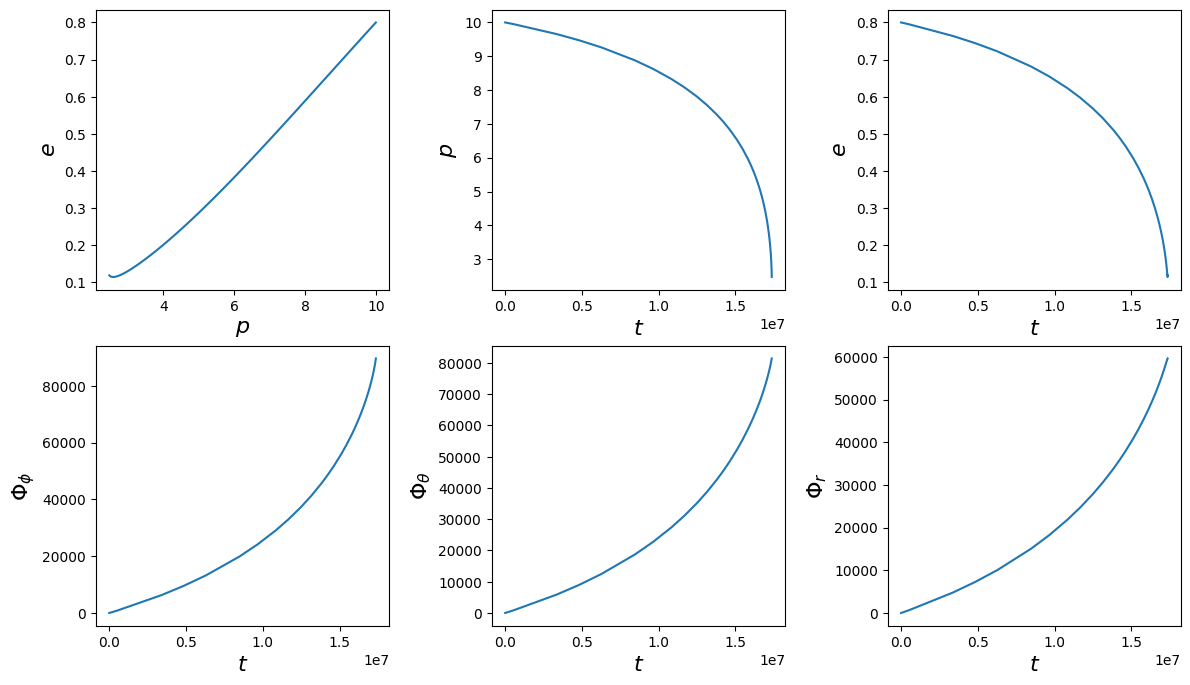

In [12]:
import matplotlib.pyplot as plt
import numpy as np

t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj_model(*traj_pars, T=T)

fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.35)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_\theta$', r'$\Phi_r$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e, p, e, Phi_phi, Phi_theta, Phi_r]
xs = [p, t, t, t, t, t]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

#### Trajectory stopping conditions

In principle, the inspiral trajectory continues until $p$ intersects with the separatrix, $p_\mathrm{sep}(a, e, x_I)$. However, FEW truncates the inspiral at the buffer point $p_\mathrm{stop} = p_\mathrm{sep} + \Delta p$ for numerical stability, performing a root-finding operation to place the last trajectory point within $\sim 10^{-8}$ of $p_\mathrm{stop}$. 

The size of $\Delta p$ can vary based on the trajectory model, and can be obtained directly from the ODE object:

In [14]:
from few.utils.utility import get_separatrix
Delta_p =  KerrEccEqFlux().separatrix_buffer_dist
print("Delta_p:", Delta_p)
p_sep = get_separatrix(a, e[-1], xI[-1])  # the separatrix at the trajectory end-point.
p[-1] - (p_sep + Delta_p)

Delta_p: 0.05


np.float64(4.97021979128931e-10)

#### Output on a requested time grid

In addition to the sparse output of the adaptive solver, the user can also construct trajectories on pre-defined time grids. For uniform grids, the sampling cadence $\mathrm{d}t$ can be supplied and the grid will be constructed automatically. Non-uniform grids can be supplied via the `new_t` keyword argument. In either case, the `fix_t` keyword argument can be used to truncate the returned trajectory at its end-point.

t1 max: 19999900.0 t2 max: 17361000.0


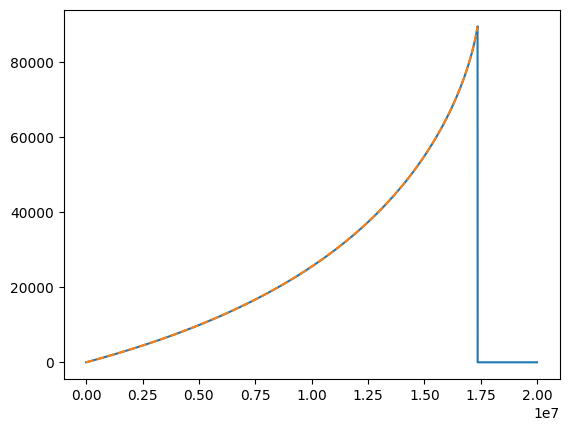

In [15]:
dt = 100.
new_t = np.arange(0, 2e7, dt) 

# a warning will be thrown if the new_t array goes beyond the time array output from the trajectory
t1, p1, e1, x1, Phi_phi1, Phi_theta1, Phi_r1 = traj_model(*traj_pars, T=T, new_t=new_t, upsample=True)

# you can cut the excess on these arrays by setting fix_t to True
t2, p2, e2, x2, Phi_phi2, Phi_theta2, Phi_r2 = traj_model(*traj_pars, T=T, new_t=new_t, upsample=True, fix_t=True)

plt.plot(t1, Phi_phi1)
plt.plot(t2, Phi_phi2, ls ='--')

print('t1 max:', t1.max(), 't2 max:', t2.max())

#### Return trajectory in dimensionless time coordinates

Trajectories are returned in coordinate time by default, but may be obtained in dimensionless time units by passing `is_coordinate_time=False`:

Dimensionless time step: 2.030254435033953


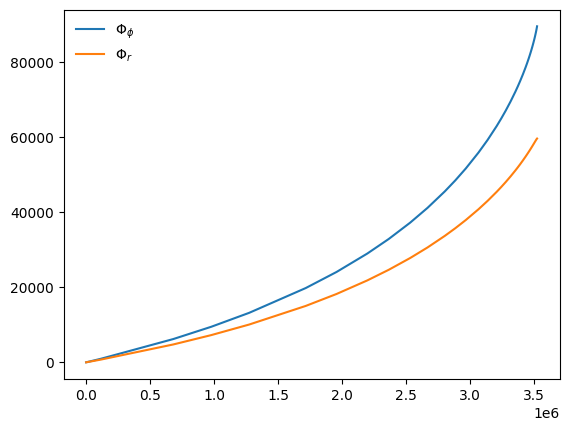

In [16]:
t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj_model(*traj_pars, in_coordinate_time=False)

plt.plot(t, Phi_phi, label=r'$\Phi_\phi$')
plt.plot(t, Phi_r, label=r'$\Phi_r$')
plt.legend(frameon=False)
print('Dimensionless time step:', t[1] - t[0])

#### Integrating trajectories with a fixed time-step

The adaptive stepping of the solver can be disabled with the `DENSE_STEPPING` keyword argument, which switches to taking uniform steps of size `dt`. This is more expensive and memory-intensive than adaptive stepping.

In [17]:
T_dense = 0.005

t_dense, p, e, x, Phi_phi, Phi_theta, Phi_r = traj_model(*traj_pars, T=T_dense, DENSE_STEPPING=1)
t_adaptive, p, e, x, Phi_phi, Phi_theta, Phi_r = traj_model(*traj_pars, T=T_dense)
t_dense.shape, t_adaptive.shape

((15780,), (8,))

We can directly verify the accuracy of the adaptive solution by evaluating its output on the densely-stepped trajectory's time grid. The phase errors will be larger than the error in the orbital elements by a factor of $M / \mu$ due to conventions chosen during integration:

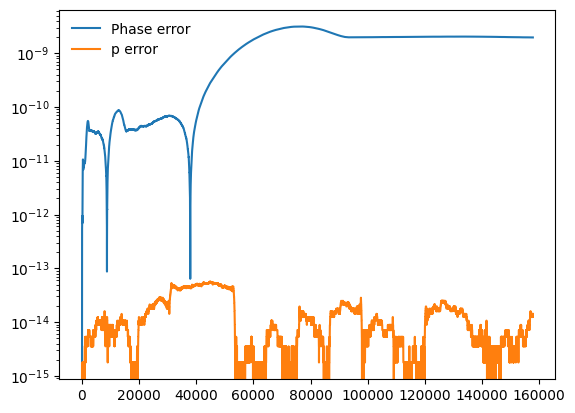

In [19]:
t_dense, p, e, x, Phi_phi, Phi_theta, Phi_r = traj_model(*traj_pars, T=T_dense, DENSE_STEPPING=1)
t_adaptive, p_adaptive, e, x, Phi_phi_adaptive, Phi_theta, Phi_r = traj_model(*traj_pars, T=T_dense, new_t=t_dense, upsample=True)

plt.semilogy(t_dense, abs(Phi_phi_adaptive - Phi_phi), label="Phase error")
plt.semilogy(t_dense, abs(p_adaptive - p), label="p error")
plt.legend(frameon=False)

#### Evolving trajectories backwards in time

Trajectories can also be evolved in reverse via the `integrate_backwards` keyword argument. Trajectories evolved in either direction will agree up to the numerical tolerance of the integrator:

np.float64(6.0975224869253e-11)

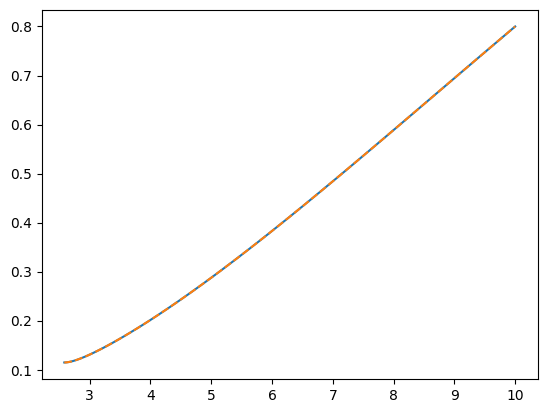

In [21]:
traj_pars_back = traj_pars.copy()

T = 0.55

# forward
t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj_model(*traj_pars, T=T)

traj_pars_back[3] = p[-1]
traj_pars_back[4] = e[-1]
traj_pars_back[5] = xI[-1]

# backward
t_back, p_back, e_back, xI_back, Phi_phi_back, Phi_theta_back, Phi_r_back = traj_model(*traj_pars_back, T=T, integrate_backwards=True)

plt.plot(p, e)
plt.plot(p_back, e_back, ls='--')
p_back[-1] - p[0]

#### Setting the integrator error tolerance

The integrator tolerance (which is an absolute tolerance) can be adjusted by setting the `err` keyword argument. Higher error tolerances reduce the number of points in the trajectory, but at the cost of numerical accuracy. Note that `err` is a _local_ error tolerance, not a global one, and must therefore be set conservatively with respect to the desired global error tolerance. The default setting of $10^{-11}$ is a reasonable value and should not need to be changed for typical scenarios. 

In [22]:
p = traj_model(*traj_pars, T=T, err=1e-11)[1]
p_hightol = traj_model(*traj_pars, T=T, err=1e-9)[1]

p.size, p_hightol.size, (p[-1]-p_hightol[-1]).item()

(63, 39, -1.3954651612024804e-07)

#### Integrating trajectories in $(E, L, Q)$ coordinates

Trajectories can also be solved in the constants of motion parameterisation $(E, L, Q)$. This is supported for all stock trajectory models. Given input $(p_0, e_0, x_{I,0})$, the integrator converts these initial conditions to $(E, L, Q)$ and integrates these quantities alongside the inspiral phases. The output trajectory is converted back to $(p, e, x_I)$ coordinates if the keyword argument `convert_pex=True` (which it is by default).

Integrating in $(E, L, Q)$ can offer some advantages, especially near the separatrix (see [Hughes 2024](https://arxiv.org/abs/2401.09577) for more information). Typically the trajectory also consists of fewer points than its $(p, e, x_I)$ counterpart, and is therefore faster to compute. However, it can also be numerically unstable for very small eccentricities, where small errors in the constants of motion can be amplified when transformed back to $(p, e, x_I)$. Usage of this method should be considered somewhat experimental, especially for eccentric and inclined (generic) inspirals.

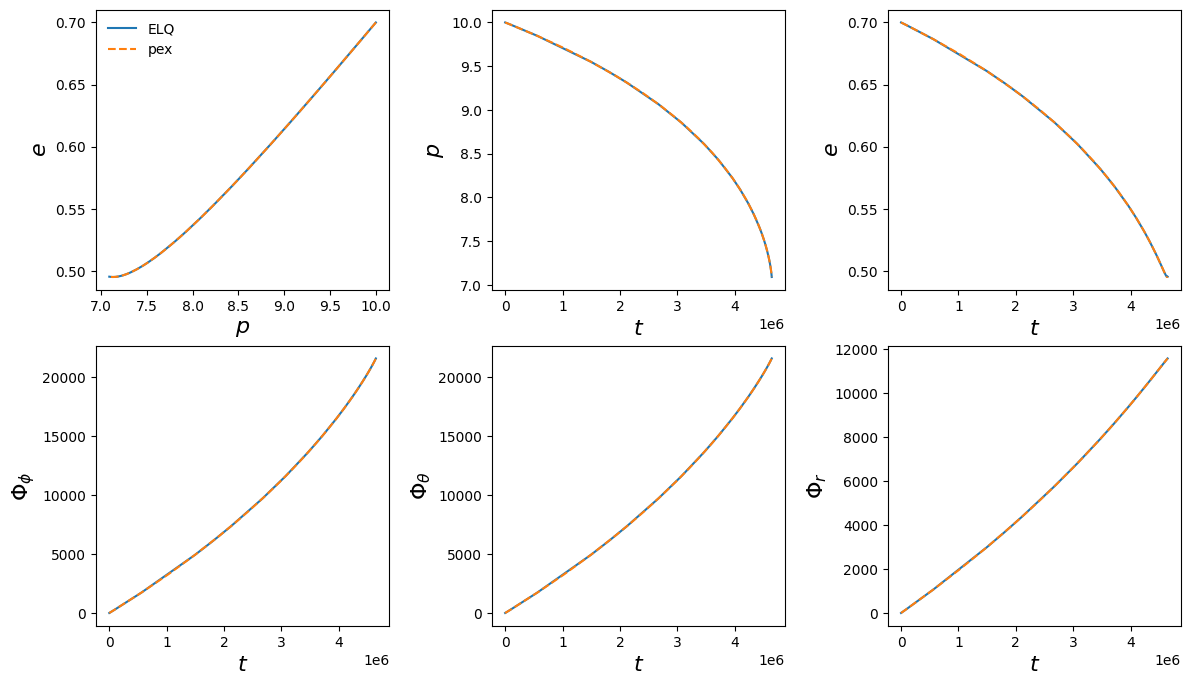

(ELQ, pex) trajectory lengths: [33, 49]
(ELQ, pex) phase difference: 0.000550540215044748


In [24]:
M = 1e6
mu = 1e2
a = 0.0
p0 = 10.0
e0 = 0.7
xI0 = 1.0
T = 1.0

traj_model_ELQ = EMRIInspiral(func=SchwarzEccFlux, integrate_constants_of_motion=True)
traj_model_pex = EMRIInspiral(func=SchwarzEccFlux, integrate_constants_of_motion=False)

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
plt.subplots_adjust(wspace=0.35)
axes = axes.ravel()
ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_\theta$', r'$\Phi_r$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']

lens = []
phase_ends = []
for traj_model, label, ls in zip([traj_model_ELQ, traj_model_pex], ['ELQ', 'pex'], ['-', '--']):
    t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj_model(M, mu, a, p0, e0, xI0, T=T)

    # Plot the results for comparison
    ys = [e, p, e, Phi_phi, Phi_theta, Phi_r]
    xs = [p, t, t, t, t, t]

    for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
        ax.plot(x, y, label=label, ls=ls)
        ax.set_xlabel(xlab, fontsize=16)
        ax.set_ylabel(ylab, fontsize=16)

    lens.append(len(t))
    phase_ends.append(Phi_phi[-1])
axes[0].legend(frameon=False)

plt.show()

print("(ELQ, pex) trajectory lengths:", lens)
print("(ELQ, pex) phase difference:", phase_ends[1] - phase_ends[0])

### User-defined trajectory models

In addition to FEW's built-in trajectory models, users can readily implement their own models in the same framework.
They can achieve this by:

- Subclassing the `ODEBase` base class,
  
- Defining the `evaluate_rhs` method, and
  
- Updating any relevant properties of the model (by default, they are set for generic Kerr inspirals).
  
You do not need to handle any boundary checking in your modified class (e.g., ensuring quantities remain physical) as this is performed automatically by the base class. 

Let's implement a Post-Newtonian trajectory in Schwarzschild eccentric as an example:

In [37]:
# Some elliptic functions for evaluating geodesic frequencies
from few.utils.elliptic import EllipK, EllipE, EllipPi

# base classes
from few.trajectory.ode.base import ODEBase

# for common interface with C/mathematica
def Power(x, n):
    return x**n

def Sqrt(x):
    return np.sqrt(x)

# this class defines the right-hand side of the ODE
# we define the method "evaluate_rhs" according to our derivatives
# we set the "equatorial" and "background" properties accordingly
# we also set the "flux_output_convention" property to "pex" to tell the trajectory module what
# the RHS derivatives correspond to
class Schwarzschild_PN(ODEBase):
    @property
    def equatorial(self):
        return True
    
    @property
    def background(self):
        return "Schwarzschild"

    @property
    def flux_output_convention(self):
        return "pex"

    def evaluate_rhs(self, y):
        # guard against bad integration steps
        p, e, xI= y[:3]

        # perform elliptic calculations
        ellipE = EllipE(4*e/(p-6.0+2*e))
        ellipK = EllipK(4*e/(p-6.0+2*e))
        ellipPi1 = EllipPi(16*e/(12.0 + 8*e - 4*e*e - 8*p + p*p), 4*e/(p-6.0+2*e))
        ellipPi2 = EllipPi(2*e*(p-4)/((1.0+e)*(p-6.0+2*e)), 4*e/(p-6.0+2*e))

        # Azimuthal frequency
        Omega_phi = (2*Power(p,1.5))/(Sqrt(-4*Power(e,2) + Power(-2 + p,2))*(8 + ((-2*ellipPi2*(6 + 2*e - p)*(3 + Power(e,2) - p)*Power(p,2))/((-1 + e)*Power(1 + e,2)) - (ellipE*(-4 + p)*Power(p,2)*(-6 + 2*e + p))/(-1 + Power(e,2)) +
              (ellipK*Power(p,2)*(28 + 4*Power(e,2) - 12*p + Power(p,2)))/(-1 + Power(e,2)) + (4*(-4 + p)*p*(2*(1 + e)*ellipK + ellipPi2*(-6 - 2*e + p)))/(1 + e) + 2*Power(-4 + p,2)*(ellipK*(-4 + p) + (ellipPi1*p*(-6 - 2*e + p))/(2 + 2*e - p)))/
            (ellipK*Power(-4 + p,2))))

        # Post-Newtonian calculations
        yPN = pow(Omega_phi,2./3.)

        EdotPN = (96 + 292*Power(e,2) + 37*Power(e,4))/(15.*Power(1 - Power(e,2),3.5)) * pow(yPN, 5)
        LdotPN = (4*(8 + 7*Power(e,2)))/(5.*Power(-1 + Power(e,2),2)) * pow(yPN, 7./2.)

        # flux
        Edot = -EdotPN
        Ldot = -LdotPN

        # time derivatives
        pdot = (-2*(Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*(3 + Power(e,2) - p)*Power(p,1.5) + Ldot*Power(-4 + p,2)*Sqrt(-3 - Power(e,2) + p)))/(4*Power(e,2) - Power(-6 + p,2))

        edot = -((Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*Power(p,1.5)*
        (18 + 2*Power(e,4) - 3*Power(e,2)*(-4 + p) - 9*p + Power(p,2)) +
        (-1 + Power(e,2))*Ldot*Sqrt(-3 - Power(e,2) + p)*(12 + 4*Power(e,2) - 8*p + Power(p,2)))/
        (e*(4*Power(e,2) - Power(-6 + p,2))*p))
        
        xIdot = 0.

        Phi_phi_dot = Omega_phi
        Phi_theta_dot = Omega_phi

        Phi_r_dot = (p*Sqrt((-6 + 2*e + p)/(-4*Power(e,2) + Power(-2 + p,2)))*np.pi)/(8*ellipK + ((-2*ellipPi2*(6 + 2*e - p)*(3 + Power(e,2) - p)*Power(p,2))/((-1 + e)*Power(1 + e,2)) - (ellipE*(-4 + p)*Power(p,2)*(-6 + 2*e + p))/(-1 + Power(e,2)) +
        (ellipK*Power(p,2)*(28 + 4*Power(e,2) - 12*p + Power(p,2)))/(-1 + Power(e,2)) + (4*(-4 + p)*p*(2*(1 + e)*ellipK + ellipPi2*(-6 - 2*e + p)))/(1 + e) + 2*Power(-4 + p,2)*(ellipK*(-4 + p) + (ellipPi1*p*(-6 - 2*e + p))/(2 + 2*e - p)))/Power(-4 + p,2))

        dydt = [pdot, edot, xIdot, Phi_phi_dot, Phi_theta_dot, Phi_r_dot]

        return dydt

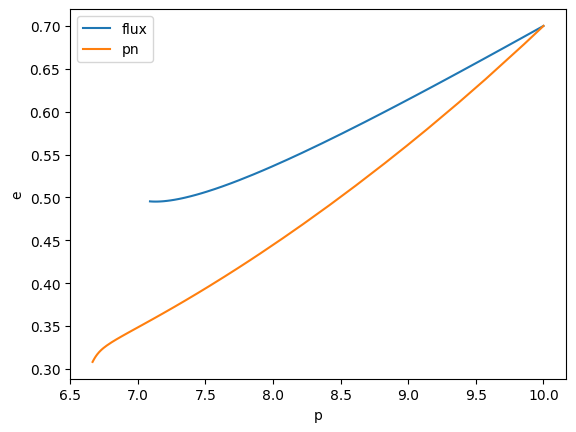

In [38]:
M = 1e6
mu = 1e2
p0 = 10.0
e0 = 0.7
T = 1.0

traj = EMRIInspiral(func=Schwarzschild_PN)

test = traj(M, mu, 0.0, p0, e0, 1.0, T=T, dt=10.0)

traj2 = EMRIInspiral(func=SchwarzEccFlux)

flux = traj2(M, mu, 0.0, p0, e0, 1.0, T=T, dt=10.0)

p = test[1]
e = test[2] 

plt.plot(flux[1], flux[2], label='flux')
plt.plot(p, e, label='pn')
plt.ylabel('e')
plt.xlabel('p')

plt.legend()

#### Modifying an existing trajectory model

In cases where the desired trajectory model can be expressed as a function of one that is supported out-of-the-box, the inbuilt model can be subclassed and supplemented as required by defining the `modify_rhs` method. This method takes as input the
current system state and the corresponding derivatives produced by the model, which can then be modified as required. 

This method does not support a return argument for efficiency; the content of the first argument `derivs` should be modified in-place.

In [39]:
from few.trajectory.ode.flux import KerrEccEqFlux

class ModifiedKerrEccEqFlux(KerrEccEqFlux):
    def modify_rhs(self, ydot, y):
        #in-place modification of the derivatives
        ydot[0] *= (1 + self.additional_args[0])
        ydot[1] *= (1 + self.additional_args[0]**0.5)

M = 1e6
mu = 1e2
a = 0.7
p = 10.
e = 0.3
x = 1.

additional_args = [0.01, ]

# Example usage
modified_ode = ModifiedKerrEccEqFlux()
modified_ode.add_fixed_parameters(M, mu, a, additional_args)

modified_ode([p, e, x])

array([-0.01162928, -0.00058962,  0.        ,  0.02761918,  0.02656476,
        0.02068311])

#### Passing additional arguments to a modified trajectory model

When calling a trajectory, the `additional_args` attribute of the ODE class will be populated with any positional arguments following $x_I$:

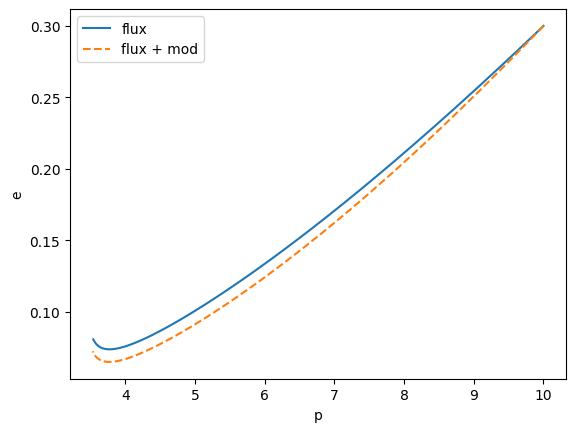

In [40]:
traj = EMRIInspiral(func=ModifiedKerrEccEqFlux)

test = traj(M, mu, a, p, e, x, 0.01, T=T, dt=10.0)

traj2 = EMRIInspiral(func=KerrEccEqFlux)

flux = traj2(M, mu, a, p, e, x, T=T, dt=10.0)

plt.plot(flux[1], flux[2], label='flux')
plt.plot(test[1], test[2], label='flux + mod', ls='--')
plt.ylabel('e')
plt.xlabel('p')

plt.legend()

The flux-based stock models perform interpolation to obtain the integral fluxes $\dot{E}$, $\dot{L}_{z}$, and then apply a Jacobian transformation in order to obtain $\dot{p}$, $\dot{e}$ if these are the variables of integration (and they are by default). In some cases, the user may wish to adjust $\dot{E}$, $\dot{L}_z$ directly if the modifications desired are more easily computed in this parameterisation. This can be achieved similarly to what was shown above, but with the `modify_rhs_before_Jacobian` method:

In [ ]:
# A physically-motivated example: dissipation of energy and angular momentum due to dynamical friction with an accretion disk
class KerrEccEqFluxAccretionDisk(KerrEccEqFlux):
    def modify_rhs_before_Jacobian(self, ydot, y):
        #in-place modification of the derivatives
        pass

traj = EMRIInspiral(func=KerrEccEqFluxAccretionDisk)

test = traj(M, mu, a, p, e, x, 0.01, T=T, dt=10.0)

traj2 = EMRIInspiral(func=KerrEccEqFlux)

flux = traj2(M, mu, a, p, e, x, T=T, dt=10.0)

plt.plot(flux[1], flux[2], label='flux')
plt.plot(test[1], test[2], label='flux + mod', ls='--')
plt.ylabel('e')
plt.xlabel('p')

plt.legend()

User-defined trajectories can be readily implemented in waveform models in the FEW framework - see TODO.

### Trajectory-related utilities

#### Get $p_0$ based on desired duration of trajectory

If you have a desired length of trajectory to analyze, this function will give you the value of $p_0$ that corresponds to the proper evolution time.

In [35]:
from few.utils.utility import get_p_at_t
traj_module = EMRIInspiral(func=SchwarzEccFlux)

# set initial parameters
M = 1e6
mu = 5e1
e0 = 0.7

traj_args = [M, mu, 0.0, e0, 1.0]
traj_kwargs = {}
index_of_p = 3

t_out = 1.5
# run trajectory
p_new = get_p_at_t(
    traj_module,
    t_out,
    traj_args,
    index_of_p=3,
    index_of_a=2,
    index_of_e=4,
    index_of_x=5,
    traj_kwargs={},
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)

print('p0 = {} will create a waveform that is {} years long, given the other input parameters.'.format(p_new, t_out))

p0 = 13.0597899788236 will create a waveform that is 1.5 years long, given the other input parameters.


#### Get $\mu$ based on desired duration of trajectory

If you have a desired length of trajectory to analyze, this function will give you the value of $\mu$ that corresponds to the proper evolution time.

In [36]:
from few.utils.utility import get_mu_at_t
traj_module = EMRIInspiral(func=SchwarzEccFlux)

# set initial parameters
M = 1e6
p0 = 11.0
e0 = 0.7

traj_args = [M, 0.0, p0, e0, 1.0]
traj_kwargs = {}
index_of_mu = 1

t_out = 1.5
# run trajectory
mu_new = get_mu_at_t(
    traj_module,
    t_out,
    traj_args,
    index_of_mu=index_of_mu,
    traj_kwargs=traj_kwargs,
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)

print('mu = {} will create a waveform that is {} years long, given the other input parameters.'.format(mu_new, t_out))

mu = 18.804307103226716 will create a waveform that is 1.5 years long, given the other input parameters.
